In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, njit, prange

In [3]:
@njit(parallel=False)
def numba_sum_axis0(x : np.array) -> np.array:
    assert len(x.shape) == 2, "Input must be 2D array shape but got shape"

    x_out = np.empty(x.shape[1])
    for i in range(x.shape[1]):
        x_out[i] = np.sum(x[:,i])
    return x_out

@njit(parallel=False)
def numba_sum_axis1(x : np.array) -> np.array:
    assert len(x.shape) == 3, "Input must be 3d array shape but got shape"

    x_out = np.empty((x.shape[0], x.shape[2]))
    for i in range(x.shape[0]):
        for j in range(x.shape[2]):
            x_out[i,j] = np.sum(x[i,:,j])
   
    return x_out

@njit(parallel=False)
def numba_sum_axis2(x : np.array) -> np.array:
    assert len(x.shape) == 3, "Input must be 3D array shape but got shape"

    x_out = np.empty((x.shape[0], x.shape[1]))
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x_out[i,j] = np.sum(x[i,j,:])
    return x_out

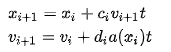
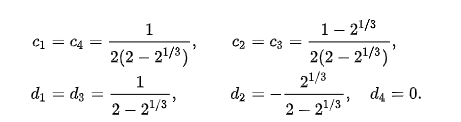

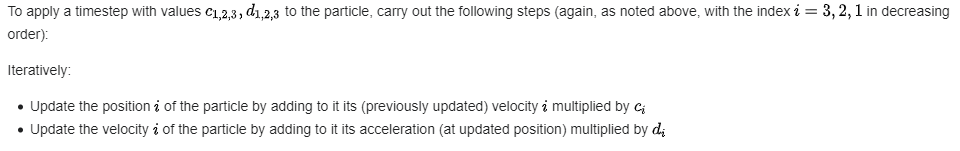

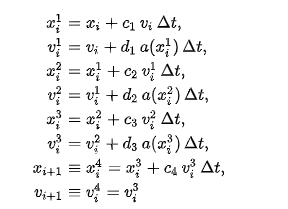

In [8]:
np.random.seed(420)


reflexive : int = 1
dt = 0.01
steps_per_orbit = 100


Cdt = 2.*np.pi / steps_per_orbit


sun_pos_vel_acc = np.zeros((1, 3, 2))
sun_mass = np.array([1.])


@njit(parallel=False)
def get_acceleration(positions, heavy_positions, heavy_masses) -> np.ndarray:

    accel = np.zeros((positions.shape[0], 2))
    for i in range(positions.shape[0]):
        for j in range(heavy_positions.shape[0]):
            dir = positions[i] - heavy_positions[j]
            dist = np.sqrt(dir[0]*dir[0] + dir[1]*dir[1])
            if dist > 0.001:
                accel[i] += -dir * 4*np.pi*np.pi* heavy_masses[j]/((dist*dist*dist))
    return accel

# def get_acceleration(positions, heavy_positions, heavy_masses) -> np.ndarray:
   
#     dir = positions[:,None] - heavy_positions
#     dist = np.sqrt(numba_sum_axis2(dir*dir))

#     acc = -dir * 4*np.pi*np.pi* heavy_masses/((dist*dist*dist))[:,:,None]

#     accelerations = numba_sum_axis1(acc)

#     # print(heavy_masses)
#     print(accelerations)
#     return accelerations



@njit
def kick(particles, heavy_particles, heavy_masses, dt) -> np.ndarray:
    """ Kick the particles using the current acceleration """

    particles[:,2] = get_acceleration(particles[:,0], heavy_particles[:,0], heavy_masses)

    particles[:,1] += particles[:,2] * (0.5*dt)

    return particles

@njit
def drift(particles, dt) -> None:
    """ Drift the particles using the current velocity """
    particles[:,0] += particles[:,1] * dt

    return particles

@njit
def single_kdk(particles, heavy_particles, heavy_masses, dt) -> tuple[np.ndarray, np.ndarray]:
    # heavy_particles = kick(heavy_particles, sun_pos_vel_acc, sun_mass, dt)
    # heavy_particles = drift(heavy_particles, dt)
    # heavy_particles = kick(heavy_particles, sun_pos_vel_acc, sun_mass, dt)

    particles = kick(particles, heavy_particles, heavy_masses, dt)
    particles = kick(particles, sun_pos_vel_acc, sun_mass, dt)
    particles = drift(particles, dt) 
    particles = kick(particles, heavy_particles, heavy_masses, dt)
    particles = kick(particles, sun_pos_vel_acc, sun_mass, dt)

    return particles, heavy_particles


@njit
def single_kdk_heavy(heavy_particles, heavy_masses, dt) -> tuple[np.ndarray, np.ndarray]:
    # heavy_particles = kick(heavy_particles, sun_pos_vel_acc, sun_mass, dt)
    # heavy_particles = drift(heavy_particles, dt)
    # heavy_particles = kick(heavy_particles, sun_pos_vel_acc, sun_mass, dt)

    heavy_particles = kick(heavy_particles, heavy_particles, heavy_masses, dt)
    heavy_particles = kick(heavy_particles, sun_pos_vel_acc, sun_mass, dt)
    heavy_particles = drift(heavy_particles, dt) 
    heavy_particles = kick(heavy_particles, heavy_particles, heavy_masses, dt)
    heavy_particles = kick(heavy_particles, sun_pos_vel_acc, sun_mass, dt)

    return heavy_particles


@njit
def leapfrog_4th(pos_vel_acc, heavy_particles, heavy_masses, dt):
    w0 = -2**(1/3)/(2-2**(1/3))
    w1 = 1/(2-2**(1/3))
    c = [w1/2, (w0+w1)/2, (w0+w1)/2, w1/2]
    d = [w1, w0, w1]
    
    xi = pos_vel_acc[:,0].copy()
    vi = pos_vel_acc[:,1].copy()

    x1 = xi + c[0]*vi*dt
    v1 = vi + d[0]*get_acceleration(x1, heavy_particles[:,0], heavy_masses)*dt
    x2 = x1 + c[1]*v1*dt
    v2 = v1 + d[1]*get_acceleration(x2, heavy_particles[:,0], heavy_masses)*dt
    x3 = x2 + c[2]*v2*dt
    v3 = v2 + d[2]*get_acceleration(x3, heavy_particles[:,0], heavy_masses)*dt
    x4 = x3 + c[3]*v3*dt

    pos_vel_acc[:,0] = x4
    pos_vel_acc[:,1] = v3
    pos_vel_acc[:,2] = get_acceleration(x4, heavy_particles[:,0], heavy_masses)

    return pos_vel_acc


# def symplectic_4th_step(pos_vel_acc, heavy_particles, heavy_masses, dt):
#     cs = [1/(2*(2-2**(1/3))), (1-2**(1/3))/(2*(2-2**(1/3))),  (1-2**(1/3))/(2*(2-2**(1/3))), 1/(2*(2-2**(1/3)))]
#     ds = [1/(2-2**(1/3)), -2**(1/3)/(2-2**(1/3)), 1/(2-2**(1/3)), 0]

#     pos = pos_vel_acc[:,0].copy()
#     vel = pos_vel_acc[:,1].copy()
#     acc = pos_vel_acc[:,2].copy()

#     for i in [0,1,2,3]:
#         pos_vel_acc = symplectic_step_i(pos_vel_acc, heavy_particles, heavy_masses, dt, i)

#     pos_vel_acc[:,0] = pos
#     pos_vel_acc[:,1] = vel
#     pos_vel_acc[:,2] = acc
#     return pos_vel_acc



@njit
def step(particles, heavy_particles, heavy_masses, dt) -> tuple[np.ndarray, np.ndarray]:  
    # if reflexive dt condition used, store old particle positions, velocities, and dts
    # # remember to use "np.copy" to take a real copy of the variables.
    # if reflexive > 0:
    #     olddt = dt
    #     old_particles = np.copy(particles)
    #     old_heavy_particles = np.copy(heavy_particles)


    # take a single KDK step
    particles, heavy_particles = single_kdk(particles, heavy_particles, heavy_masses, dt)

    # particles = symplectic_4th_step(particles, heavy_particles, heavy_masses, dt)
    # heavy_particles = symplectic_4th_step(heavy_particles, sun_pos_vel_acc, sun_mass, dt)
   
    # for i in [0,1,2,3]:
    #     particles = symplectic_step_i(particles, heavy_particles, heavy_masses, dt, i)
    #     heavy_particles = symplectic_step_i(heavy_particles, sun_pos_vel_acc, sun_mass, dt, i)


    # heavy_particles = leapfrog_4th(heavy_particles, sun_pos_vel_acc, sun_mass, dt)
    # heavy_plus_sun = np.concatenate((heavy_particles, sun_pos_vel_acc), axis=0)
    # heavy_masses_plus_sun = np.concatenate((heavy_masses, sun_mass), axis=0)
    # # particles = leapfrog_4th(particles, sun_pos_vel_acc, sun_mass, dt)
    # particles = leapfrog_4th(particles, heavy_plus_sun, heavy_masses_plus_sun, dt)

    # particles = rk4(particles, heavy_particles, heavy_masses, dt)

    # if reflexive dt condition used, recompute dt, and
    # use averaged dt to redo the KDK step "reflexive" times
    # from stored positions and velocities
    # if reflexive > 0:
    #     # make n more iteration for completeness
    #     for _ in prange(reflexive):
    #     # courant(particles,heavy_particles)
    #         dt = courant(heavy_particles)
    #         self.dt = 0.5*(self.dt + olddt)

    #         particles = np.copy(old_particles)
    #         heavy_particles = np.copy(old_heavy_particles)
            
    #         particles, heavy_particles = single_kdk(particles, heavy_particles, heavy_masses, dt)

    return particles, heavy_particles

@njit
def courant(pos_vel_acc, kepler_speeds) -> float:
    acceleration = pos_vel_acc[:,2]
    acc = np.sqrt(numba_sum_axis0(acceleration*acceleration))
    dts = Cdt * kepler_speeds / acc

    return np.min(dts)

@njit
def get_energy(particles, heavy_particles, heavy_masses) -> float:
    pot = 0.
    for i in range(particles.shape[0]):
        for j in range(heavy_particles.shape[0]):
            dir = particles[i,0] - heavy_particles[j,0]
            dist = np.sqrt(dir[0]*dir[0] + dir[1]*dir[1])
            pot += -4*np.pi*np.pi* heavy_masses[j]/dist


    kin = 0.
    for i in range(particles.shape[0]):
        kin += 0.5*np.sum(particles[i,1]*particles[i,1])
    return kin + pot

@njit
def rk4(pos_vel_acc, heavy_particles, heavy_masses, dt):
    dr1 = dt * pos_vel_acc[:,1]
    dv1 = dt * get_acceleration(pos_vel_acc[:,0], heavy_particles[:,0], heavy_masses)
    
    dr2 = dt * (pos_vel_acc[:,1] + 0.5 * dv1*dt)
    dv2 = dt * get_acceleration(pos_vel_acc[:,0] + 0.5 * dr1, heavy_particles[:,0], heavy_masses)
    
    dr3 = dt * (pos_vel_acc[:,1] + 0.5 * dv2*dt)
    dv3 = dt * get_acceleration(pos_vel_acc[:,0] + 0.5 * dr2, heavy_particles[:,0], heavy_masses)
    
    dr4 = dt * (pos_vel_acc[:,1] + dv3*dt)
    dv4 = dt * get_acceleration(pos_vel_acc[:,0] + 0.5 * dr3, heavy_particles[:,0], heavy_masses)
    
    pos_vel_acc[:,0] += (dr1 + 2.*dr2 + 2.*dr3 + dr4) / 6.
    pos_vel_acc[:,1] += (dv1 + 2.*dv2 + 2.*dv3 + dv4) / 6.

    return pos_vel_acc



@njit
def main(dt):
    N_dust = 400
    N_heavy = 0
    pos_vel_acc = np.zeros((N_dust, 3, 2))
    kepler_speeds = np.zeros(N_dust)
    GM = 4. * np.pi*np.pi * 1



    dists = np.linspace(2., 4., N_dust)
    for i in range(N_dust):
        # dist = 1.5 + np.random.uniform()*3.5
        dist = dists[i]
        e = 0.
        a = dist/(1 + e)
        vm = np.sqrt(GM*(2/dist - 1/a))           # Kepler speed
        angle = np.random.uniform()*2*np.pi

        vx = -vm*np.sin(angle)
        vy = +vm*np.cos(angle) 

        pos_vel_acc[i,0,0] = np.cos(angle)*dist
        pos_vel_acc[i,0,1] = np.sin(angle)*dist
        pos_vel_acc[i,1,0] = vx
        pos_vel_acc[i,1,1] = vy
        kepler_speeds[i] = vm

        
    heavy_pos_vel_acc = np.zeros((N_heavy, 3, 2))
    heavy_masses = np.ones(N_heavy)*0.0009543
    # heavy_masses[0] = 0.0001655 # Mercury: 0.0001655 solar masses
    # heavy_masses[1] = 0.002564  # Venus: 0.002564 solar masses
    # heavy_masses[2] = 0.003145# Earth: 0.003145 solar masses
    # heavy_masses[3] = 0.0003325# Mars: 0.0003325 solar masses
    # heavy_masses[4] = 0.0009543 # Jupiter: 0.0009543 solar masses
    # heavy_masses[5] = 0.0002858 # Saturn: 0.0002858 solar masses
    # heavy_masses[6] = 0.0000436  # Uranus: 0.0000436 solar masses
    # heavy_masses[7] = 0.0000542 # Neptune: 0.0000542 solar masses
    # heavy_masses[8] = 0.000000219 # Pluto: 0.000000219 solar masses

    # heavy_masses = 
    # distances_au = [
    #                 0.39,   # Mercury
    #                 0.72,   # Venus
    #                 1.00,   # Earth, approximately
    #                 1.52,   # Mars
    #                 5.20,   # Jupiter
    #                 9.58,   # Saturn
    #                 19.22,  # Uranus
    #                 30.05,  # Neptune
    #                 39.48   # Pluto
    #             ]


    for i in range(N_heavy):
        dist = 5.2
        e = 0.
        a = dist/(1 + e)
        vm = np.sqrt(GM*(2/dist - 1/a))     # Kepler speed

        angle = np.random.uniform()*2*np.pi
        
        vx = -vm*np.sin(angle)
        vy = +vm*np.cos(angle) 

        heavy_pos_vel_acc[i,0,0] = np.cos(angle)*dist 
        heavy_pos_vel_acc[i,0,1] = np.sin(angle)*dist
        heavy_pos_vel_acc[i,1,0] = vx
        heavy_pos_vel_acc[i,1,1] = vy

    n_steps = int(1e6)

    save_last = int(1e4)#10_000

    all_positions = np.zeros((save_last, N_dust, 2))
    all_heavy_positions = np.zeros((save_last, N_heavy, 2))

    energies = np.zeros(n_steps)

    for i in prange(n_steps):
        pos_vel_acc, heavy_pos_vel_acc = step(pos_vel_acc, heavy_pos_vel_acc, heavy_masses, dt)
        if i >= n_steps-save_last:
            ii = i-(n_steps-save_last)
            all_positions[ii] = pos_vel_acc[:,0,:]
            all_heavy_positions[ii] = heavy_pos_vel_acc[:,0,:]
        
        # energies[i] = get_energy(pos_vel_acc, sun_pos_vel_acc, sun_mass)
    


    return all_positions, all_heavy_positions, energies



all_positions, all_heavy_positions, energies = main(dt)



In [9]:
first_distances = np.linspace(2., 4., 400)

distances = np.sqrt(np.sum(all_positions*all_positions, axis=2))

kdk_off = np.abs(distances - first_distances[None,:])/first_distances[None,:]

In [10]:
import seaborn as sns

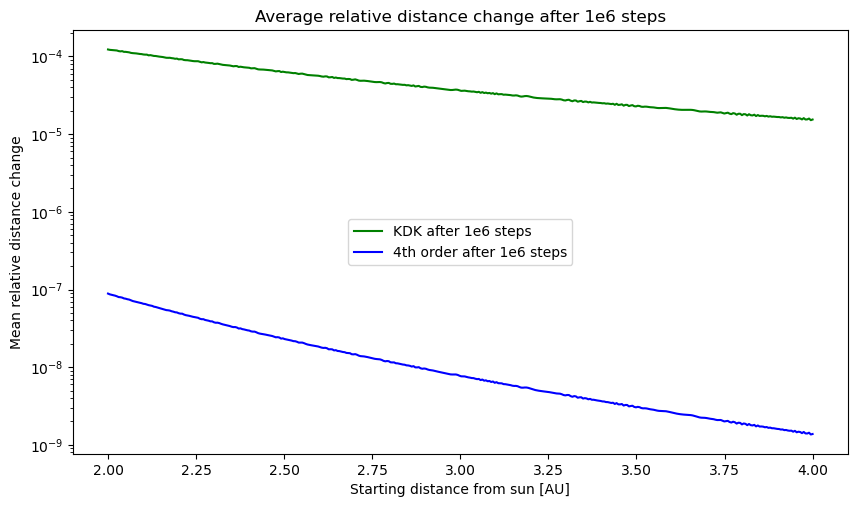

In [15]:
x = first_distances

fig, axs = plt.subplots(1,1, figsize=(10,5.5), sharey=True)
# axs[0].plot(x, kdk_off.mean(axis=0), label="KDK")

# plt.plot(x, kdk_off_1e4.mean(axis=0),':', label="KDK after 1e4 steps", color = "green")
plt.plot(x, kdk_off.mean(axis=0), label="KDK after 1e6 steps", color = "green")

# axs.plot(x, symp_off_1e4.mean(axis=0), ':',label="4th order after 1e4 steps",  color = "blue")
axs.plot(x, symp_off.mean(axis=0),  label="4th order after 1e6 steps", color = "blue")


axs.title.set_text("Average relative distance change after 1e6 steps")

axs.set_xlabel("Starting distance from sun [AU]")
axs.set_ylabel("Mean relative distance change")
axs.set_yscale("log")
axs.legend(loc = "center")


# sns.despine()

# plt.yscale("log")

In [26]:
np.save("dumb_energies1e6.npy", energies)

In [ ]:
# np.std(energies)
# dumb_energies = energies.copy()

In [47]:
smart_energies

array([0., 0., 0., ..., 0., 0., 0.])

In [46]:
energies

array([0., 0., 0., ..., 0., 0., 0.])

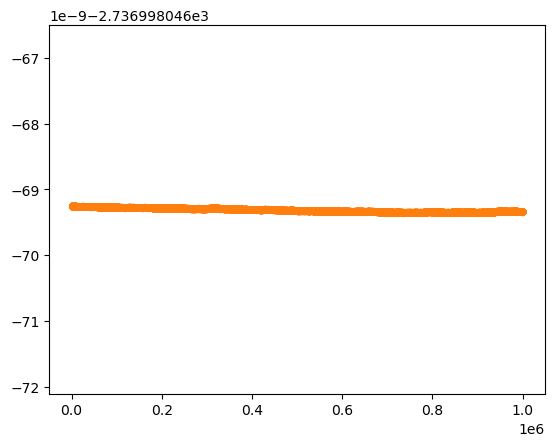

In [29]:
plt.plot(energies,'.')
plt.plot(smart_energies,'.')

In [4]:
# smart_energies = energies.copy()

In [ ]:
np.save("400positions1e6_4th_w_saturn.npy", all_positions)
np.save("1heavypositions1e6_4th_w_saturn.npy", all_heavy_positions)

In [81]:
all_positions

array([[[ 4229.75645043, -1206.48331952],
        [-2191.37553779, -3807.35456836],
        [-2602.16267981,  3532.52036063],
        ...,
        [ 3111.6168306 ,  -124.01614762],
        [-3032.52533529,   699.4011033 ],
        [ -415.29315014,  3082.33132783]],

       [[ 4229.76072346, -1206.48453624],
        [-2191.37774954, -3807.35841518],
        [-2602.16530988,  3532.52392763],
        ...,
        [ 3111.6199738 ,  -124.01626886],
        [-3032.52839935,   699.40180583],
        [ -415.29357363,  3082.33444075]],

       [[ 4229.76499649, -1206.48575297],
        [-2191.3799613 , -3807.362262  ],
        [-2602.16793996,  3532.52749462],
        ...,
        [ 3111.623117  ,  -124.0163901 ],
        [-3032.5314634 ,   699.40250836],
        [ -415.29399712,  3082.33755367]],

       ...,

       [[ 4272.47393333, -1218.64692756],
        [-2213.48642915, -3845.81121079],
        [-2628.45557593,  3568.17959833],
        ...,
        [ 3143.03939572,  -125.2281982 ],
     

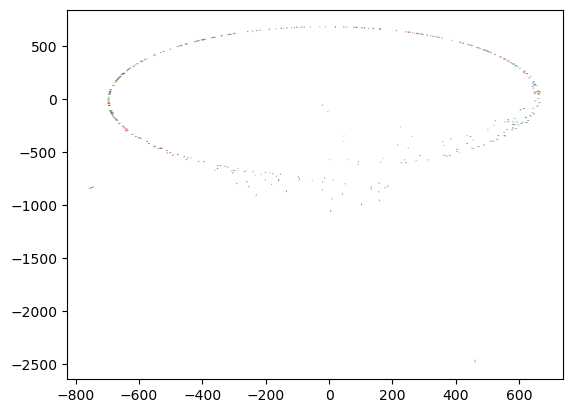

In [52]:
plotn = 10000

# plt.plot(all_positions[0,:,0],all_positions[0,:,1],'.')
plt.plot(all_positions[:plotn,:,0],all_positions[:plotn,:,1], lw = 0.5)
# plt.plot(all_heavy_positions[:plotn,0,0],all_heavy_positions[:plotn,0,1])
# plt.plot(all_heavy_positions[0,0,0],all_heavy_positions[0,0,1],'o')


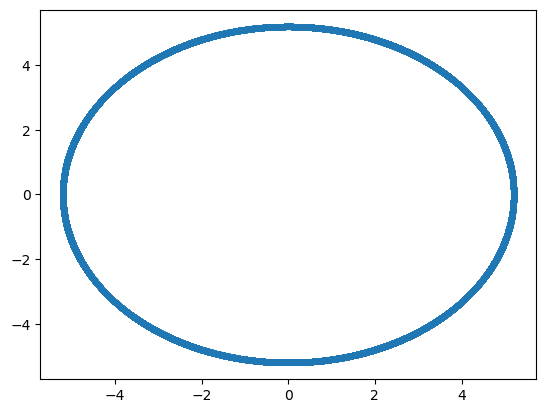

In [41]:
np.save("400positions1e7_4th.npy", all_positions)
np.save("1heavypositions1e7_4th.npy", all_heavy_positions)

In [7]:
import seaborn as sns

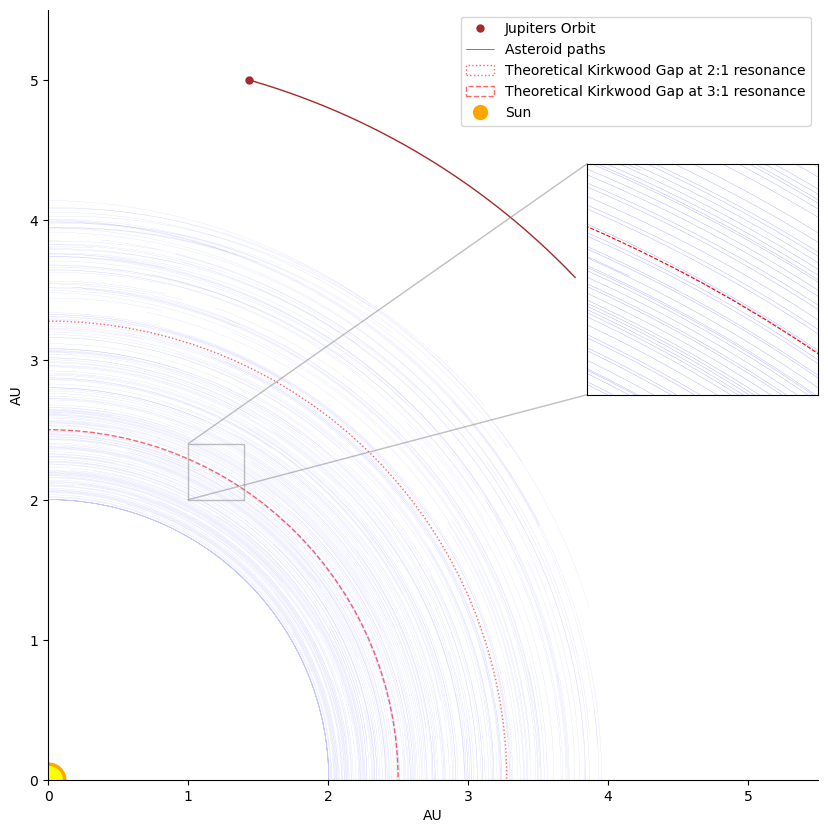

In [8]:
# all_positions = np.load("400positions1e9_4th.npy")
# all_heavy_positions = np.load("1heavypositions1e9_4th.npy")

def P_from_a(a):
    return np.sqrt(4*np.pi**2*a**3)

def a_from_P(P):
    return (P**2/(4*np.pi**2))**(1/3)



a_jupiter = 5.2
P_jupiter = P_from_a(a_jupiter)


last_n = 2000

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')

ax.plot(all_heavy_positions[-1200:-200,0,0], all_heavy_positions[-1200:-200,0,1], c = 'brown', lw=1)
ax.plot(all_heavy_positions[-200,0,0], all_heavy_positions[-200,0,1], '.', c = 'brown', markersize=10, label = "Jupiters Orbit")


ax.plot(all_positions[-last_n:,:,0], all_positions[-last_n:,:,1], c = 'blue', alpha=0.3, lw=0.1)
ax.plot(all_positions[-last_n:,0,0], all_positions[-last_n:,0,1], c = 'blue', alpha=1, lw=0.4, label = "Asteroid paths")
ax.plot(all_positions[-last_n:,0,0], all_positions[-last_n:,0,1], c = "white", alpha=1, lw=0.45, )

for ii, frac in enumerate([1/2, 1/3, ]):
    distance = a_from_P(P_jupiter*frac)

    # plot circle at distance
    names = ["2:1", "3:1", ]
    lss = [":", "--"]

    circle = plt.Circle((0, 0), distance, ls = lss[ii],color='red', fill=False, lw = 1, alpha = 0.6, label = "Theoretical Kirkwood Gap at " + names[ii] + " resonance")
    ax.add_artist(circle)

# for frac in [1/5, 1/4, 2/5, 2/3, 3/4]:
#     distance = a_from_P(P_jupiter*frac)

#     # plot circle at distance
#     circle = plt.Circle((0, 0), distance, ls = '--',color='black', fill=False, alpha = 0.2)
#     ax.add_artist(circle)

# make inset axis for zoom
axins = ax.inset_axes([.7, .5, 0.3, 0.3])
axins.set_aspect('equal')
axins.plot(all_positions[-last_n:,:,0], all_positions[-last_n:,:,1], c = 'blue', alpha=1, lw=0.1)
axins.set_xlim(1,1.4)
axins.set_ylim(2,2.4)
frac = 1/3
distance = a_from_P(P_jupiter*frac)
circle = plt.Circle((0, 0), distance, ls = '--',color='red', fill=False, lw = .8, alpha = 1,)
axins.add_artist(circle)
axins.set_xticks([])
axins.set_yticks([])
ax.indicate_inset_zoom(axins)


ax.plot([0], [0], 'o', color='orange', markersize=25)
ax.plot([0], [0], 'o', color='orange', markersize=10, label = "Sun")
ax.plot([0], [0], 'o', color='yellow', markersize=20)
sns.despine()
ax.legend()
ax.set_xlim(0,5.5)
ax.set_ylim(0,5.5)
ax.set_xlabel("AU")
ax.set_ylabel("AU")
plt.show()

(-1.0, 10.0)

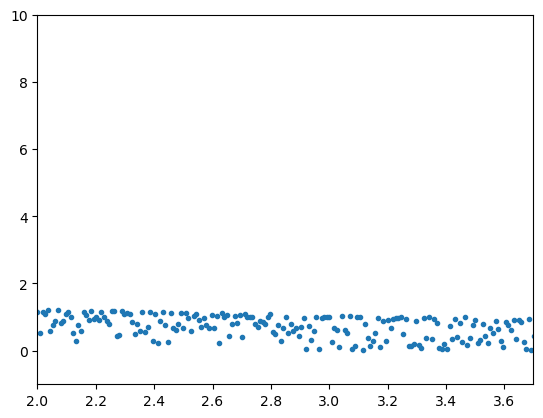

In [36]:
last_dists = np.sqrt(all_positions[-1]**2).sum(axis=1)
start_dists = np.linspace(1.5, 5.0, last_dists.shape[0])



plt.plot(start_dists, np.abs(start_dists - last_dists), '.', alpha=1)
plt.xlim(2, 3.7)
plt.ylim(-1,10)
# plt.ylim(

In [236]:
last_n = 9999999

xx = all_positions[-last_n:,:,0]
yy = all_positions[-last_n:,:,1]


yy = yy[(xx > 2)*(xx<3.75)]
xx = xx[(xx > 2)*(xx<3.75)]

xx = xx[(yy < 0.01)*(yy > -0.01)]
yy = yy[(yy < 0.01)*(yy > -0.01)]


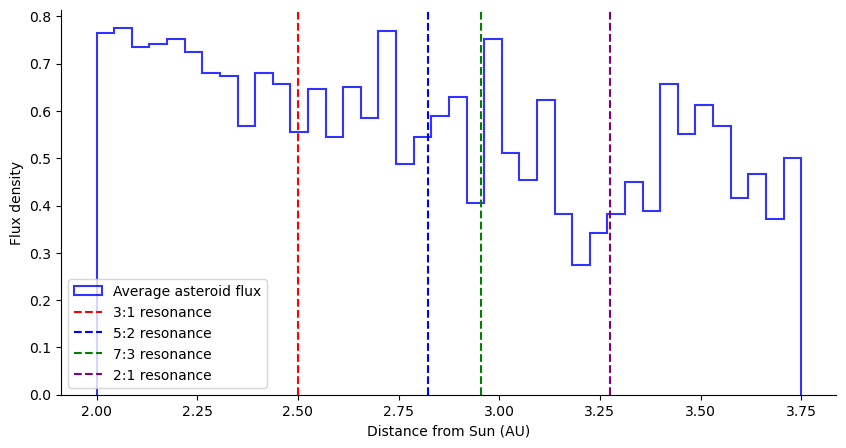

In [237]:
fig, ax = plt.subplots(figsize=(10,5))

ax.hist(xx, bins=40,  alpha=.8, density=True,histtype='step', label = "Average asteroid flux", color = "blue", align='mid', lw = 1.5)

names =  ["2:1",   "7:3",  "5:2","3:1"][::-1]
colors = ["red", "blue", "green", "purple"]

for name, color, frac in zip(names, colors, [1/3,  2/5, 3/7, 1/2]):
    distance = a_from_P(P_jupiter*frac)

    ax.axvline(distance, ls = '--',color=color,label = name + " resonance")

ax.set_xlabel("Distance from Sun (AU)")
ax.set_ylabel("Flux density")
ax.legend()
sns.despine()
plt.show()